### Выберите ряд из первого задания и постройте его модель ARIMA. Отчет нужно будет оформить в jupyter-ноутбук.

In [15]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings

warnings.filterwarnings("ignore")

In [16]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [17]:
sales = pd.read_csv('Series/monthly-sales-of-company-x-jan-6.csv')

In [18]:
sales = sales['Count']

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


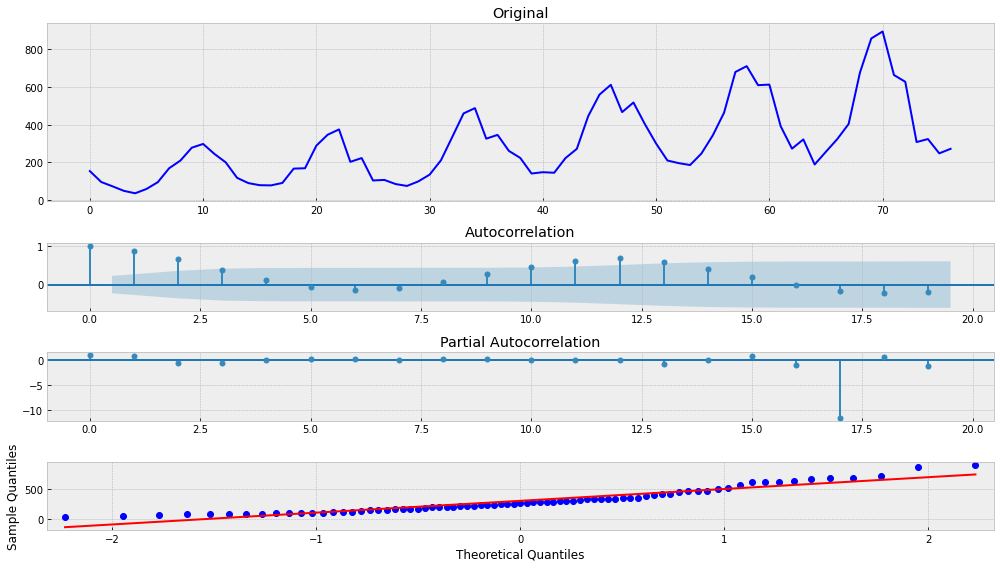

In [19]:
tsplot(sales)

In [20]:

best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(10):
    for d in range(10):
        for j in range(10):
            try:
                
                tmp_mdl = smt.ARIMA(sales, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 858.17298 | order: (3, 1, 2)


In [21]:
i, d, j = best_order

In [22]:
mdl_arima = smt.ARIMA(sales, order=(i,d,j)).fit(method='mle', trend='nc')

Results of Dickey-Fuller Test:
Test Statistic                 -2.024893
p-value                         0.275766
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


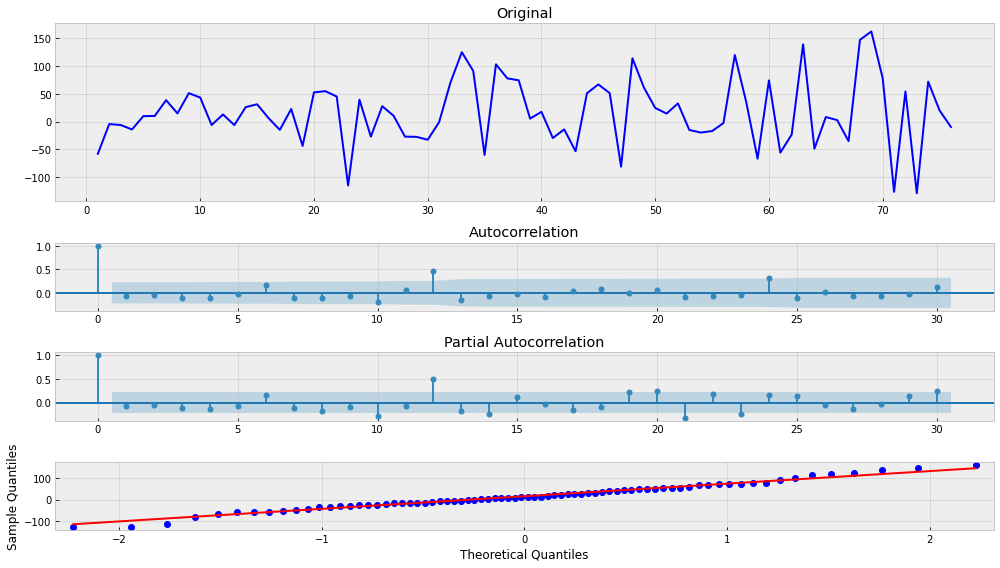

In [23]:
tsplot(mdl_arima.resid, lags=30)

Смоделированный с подбором оптимальных параметров ряд при вычитании оригинального ряда не выдает шума, p_value = 0,276

Уменьшим дисперсию с помощью преобразования Бокса-Кокса

In [24]:
sales_b = boxcox(sales, 0)

Results of Dickey-Fuller Test:
Test Statistic                 -0.908049
p-value                         0.785310
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


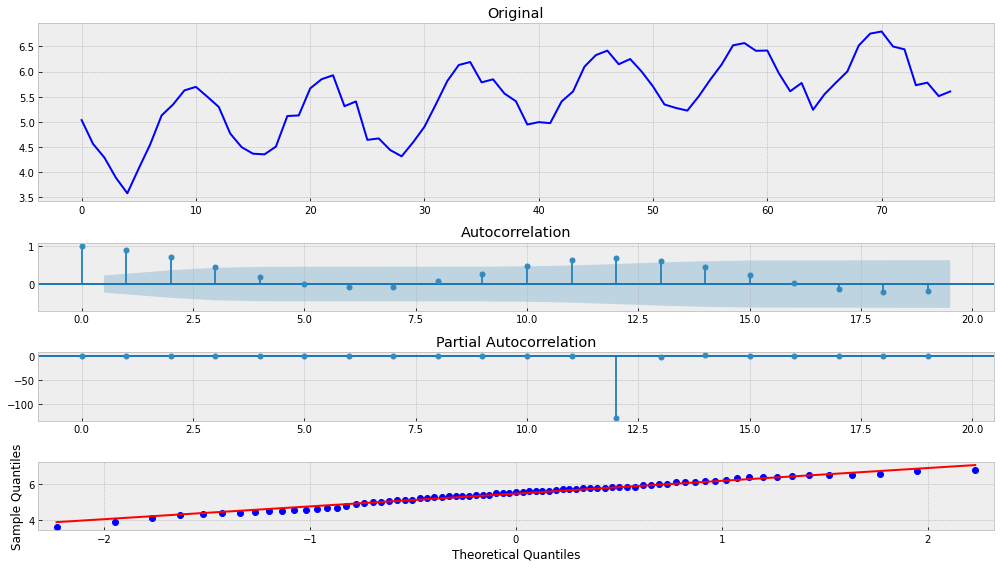

In [25]:
tsplot(sales_b)

In [26]:

best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(10):
    for d in range(10):
        for j in range(10):
            try:
                
                tmp_mdl = smt.ARIMA(sales_b, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: -37.58415 | order: (7, 1, 2)


In [27]:
best_order

(7, 1, 2)

Results of Dickey-Fuller Test:
Test Statistic                -9.483184e+00
p-value                        3.823966e-16
#Lags Used                     0.000000e+00
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (5%)           -2.900925e+00
Critical Value (10%)          -2.587781e+00
dtype: float64


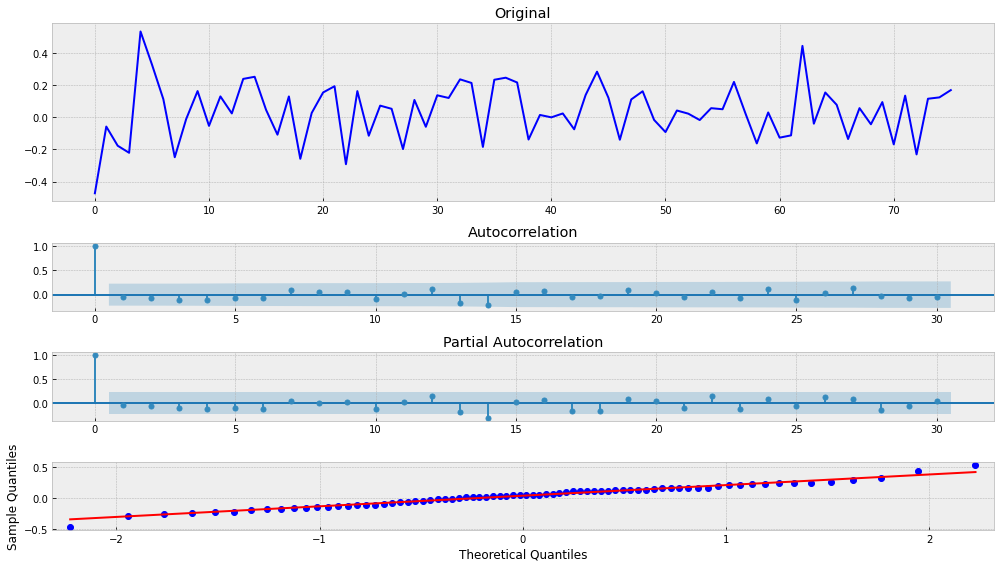

In [28]:
tsplot(best_mdl.resid, lags=30)

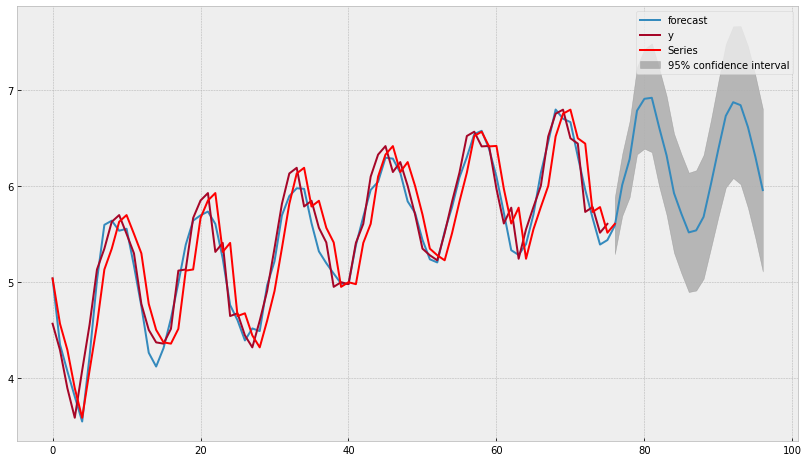

In [29]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(sales_b)+20, ax=ax)
    plt.plot(sales_b, color='red', label='Series')
    plt.legend()
    plt.show()